In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4,5]; pair_2 = [6,7,8] 
pair_3 = [9,10,11,12]; pair_4 = [13,14,15]
triplet_1 = [16,17,18,19] 
triplet_2 = [20,21,22,23]
triplet_3 = [24,25,26,27,28,29]

def select_cluster(df_corr, clusters):
    if len(clusters) > 1:
        clus = []
        for i in clusters:
            clus = clus + i
    else:
        clus = clusters
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def regularize_dos(df_dos, grid_fine, smooth_width=0, log=False):
    df_dos_fine = pd.DataFrame(index=df_dos.index, columns=['dos_hse'])
    for i in df_dos.index:
        dos = df_dos.loc[i, "dos_hse"]
        grid_coarse = df_dos.loc[i, "energy_hse"]
        if smooth_width > 0:
            box = np.ones(smooth_width)/smooth_width
            dos = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,dos)
        df_dos_fine.loc[i,"dos_hse"] = f(grid_fine)
    if log:
        _dos_log = df_dos_fine.copy()
        for i in df_dos_fine.index:
            _dos_log.loc[i,'dos_hse'] = np.log(df_dos_fine.loc[i,'dos_hse']+0.1)
        df_dos_fine = _dos_log
    return df_dos_fine

def weight(df_dos, w_exp):
    w = np.exp(df_dos.gap_hse.values.astype(float)/w_exp)
    #w = np.ones(len(df_dos))
    return w

def _to_array(x):
    xx = np.zeros((len(x.values), len(x.values[0])))
    for i in range(len(x.values)):
        xx[i] = x.values[i]
    return xx

def _norm(x, stats):
    return (x - stats['mean'])/stats['std']

def plot_hist(history):
    plt.rcParams['figure.figsize'] = [8,6]
    fig, ax1 = plt.subplots(1)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    ax1.plot(hist['epoch'], hist['mean_squared_error'], label='Training')
    ax1.plot(hist['epoch'], hist['val_mean_squared_error'], label='Test')
    ax1.legend()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    plt.show()

def model_init(num_corr, num_energy, num_units):
    l2 = {"kernel_regularizer":keras.regularizers.l2(0.001)}
    model = keras.Sequential()
    model.add(layers.Dense(num_units, activation=tf.nn.relu, input_shape=(num_corr,)))
    model.add(layers.Dense(num_units, activation=tf.nn.relu))
    model.add(layers.Dense(num_energy))
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
    return model

def data_init(mat, clusters, w_exp=0.1, align=False, verbose=False):
    global grid_fine, df_dos_fine, ref_ind
    smooth_width = 5 # the box width used to smooth the density of states
    is_log = False
    # grid_fine = np.arange(2,8,0.02) # grid for the selected energy range
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}.csv'.format(mat), delim_whitespace=True)
    df_dos = pd.read_hdf('dos_{0}.h5'.format(mat))
    # semiconductors only
    # drop metallic structures
    semi = df_dos[(df_dos.gap_hse > 0.2) & (df_dos.has_hse) & (df_dos.ref_hse < -128)].index
    df_corr = df_corr.loc[semi]
    df_dos = df_dos.loc[semi]
    ref_ind = df_dos.gap_hse.idxmax()
    if verbose:
        display(df_dos)
    # interpolate the dos on a specific regular mesh
    # df_dos_fine = regularize_dos(df_dos, grid_fine, smooth_width=smooth_width, log=is_log)
    # alignment wrt Sn-4s
    if align:
        ref_level = df_dos.loc[ref_ind, 'ref_hse']
        delta_ref = df_dos['ref_hse'] - ref_level
        df_dos['dos_hse'] -= delta_ref 
    
        if verbose:
            display(df_dos)
    # keep original mesh and data
    df_dos_fine = df_dos
    grid_fine = df_dos.iloc[0]['energy_hse']
    # define training set
    train = df_corr.sample(frac=0.9)
    df_corr_train = train.loc[:,"corr(0)":"corr(29)"]
    dos_train = df_dos_fine.loc[train.index,'dos_hse']
    # test set
    test = df_corr.drop(train.index)
    df_corr_test = test.loc[:,"corr(0)":"corr(29)"]
    dos_test = df_dos_fine.drop(train.index).loc[:,'dos_hse']
    # include the pair interactions up to the 5th NN, and the triplets up to the 2NN
    corr_train = select_cluster(df_corr_train, clusters)
    corr_test = select_cluster(df_corr_test, clusters)
    # normalize the input
    stats = corr_train.describe()
    stats = stats.transpose()
    stats['std'][stats['std'] < 1e-4] = 1
    corr_train = _norm(corr_train, stats)
    corr_test = _norm(corr_test, stats)
    #
    dos_train = _to_array(dos_train)
    dos_test = _to_array(dos_test)
    return corr_train, dos_train, corr_test, dos_test
   
def ecdos(mat,clusters,model,vbm,write=False):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(30):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    # normalize the corr
    stats = corr_mc.describe()
    stats = stats.transpose()
    stats['std'][stats['std'] < 1e-4] = 1
    corr_mc = _norm(corr_mc, stats)
    #
    dos_mc_pred = model.predict(corr_mc)
    # 
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, ax = plt.subplots(1)
    norm = mpl.colors.Normalize(vmin=df_mc["T"].min(), vmax = df_mc["T"].max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in df_mc["T"]]
    ax.set_xlim([-0.5,2.2])
    ax.set_ylim([-.2, 8])
    # ax.tick_params(labelleft=False)
    grid_ = grid_fine - vbm
    for i in range(len(dos_mc_pred)):
        ax.plot(grid_, dos_mc_pred[i]+df_mc.loc[i,"T"]*0./400, color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference dos
    ax.plot(grid_, df_dos_fine.loc[ref_ind, "dos_hse"], '--', c='k', label='reference at LT')
    ax.set_xlabel(r'$E-E_{VBM}$ (eV)')
    ax.set_ylabel(r'Temperature-dependent DOS')
    ax.text(0.4, 0.8, mat.upper(), transform=ax.transAxes, fontsize=12)
    ax.legend()
    if write:
        plt.savefig('{0}_dos.pdf'.format(mat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1000)              7000      
_________________________________________________________________
dense_34 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_35 (Dense)             (None, 1501)              1502501   
Total params: 2,510,501
Trainable params: 2,510,501
Non-trainable params: 0
_________________________________________________________________


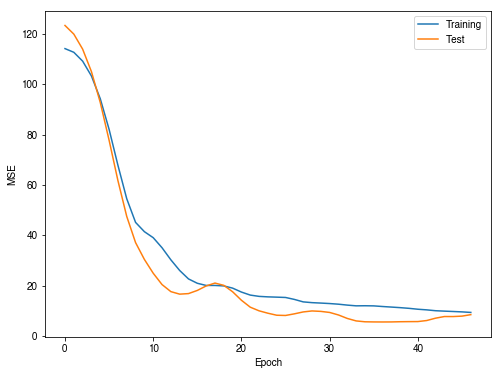

In [35]:
clusters = [pair_1, pair_2]
corr_train, dos_train, corr_test, dos_test = data_init('czts', clusters)
model = model_init(len(corr_train.keys()), len(dos_train[0]), 1000)
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(corr_train, dos_train, epochs=200, validation_data=(corr_test, dos_test), callbacks=[early_stop], verbose=0)
plot_hist(history)

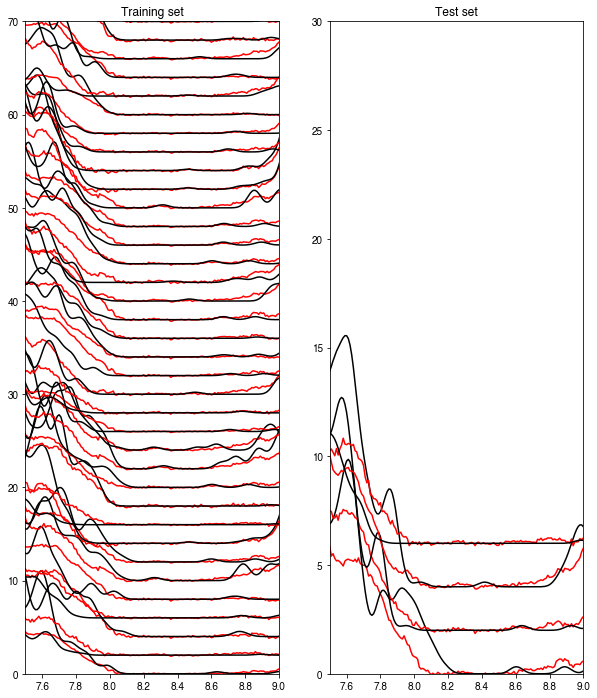

In [36]:
plt.rcParams['figure.figsize'] = [10, 12]
fig, (ax1, ax2) = plt.subplots(1,2)
dos_pred = model.predict(corr_train)
for i in range(len(corr_train)):
    ax1.plot(grid_fine, dos_pred[i]+2*i, 'r')
    ax1.plot(grid_fine, dos_train[i]+2*i, 'k')
ax1.set_xlim([7.5, 9])
ax1.set_ylim([0,70])
ax1.set_title("Training set")
dos_pred = model.predict(corr_test)
for i in range(len(corr_test)):
    ax2.plot(grid_fine, dos_pred[i]+2*i, 'r')
    ax2.plot(grid_fine, dos_test[i]+2*i, 'k')
ax2.set_xlim([7.5, 9])
ax2.set_ylim([0,30])
ax2.set_title("Test set")
plt.show()

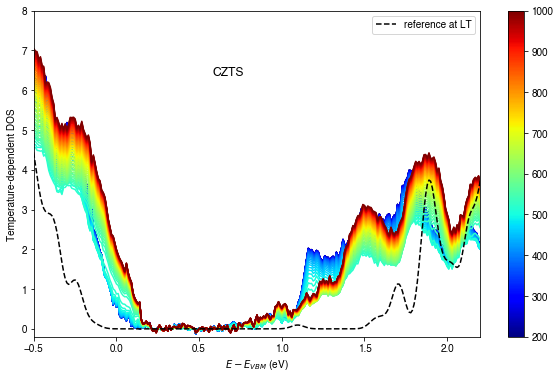

In [37]:
ecdos('czts',clusters,model,7.88,write=False)